In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
from utils.eval import *

In [3]:
from IPython.core.display import display, HTML
display(
   HTML("<style>.container { width:95% !important; }</style>"))
display(
   HTML("<style>.prompt { font-size: 10px !important; }</style>"))

## Config

In [4]:
data_path = "data/"

In [5]:
cmap = plt.cm.Reds

In [6]:
data = 'train'

## Load data

In [7]:
df = pd.read_csv(data_path + data + '.csv', sep='\t', encoding='utf-8', )  
df.head()

,installments.quantity,installments.rate,id,site_id,title,price,currency_id,available_quantity,sold_quantity,buying_mode,...,address.state_name,shipping.free_shipping,shipping.mode,shipping.logistic_type,shipping.store_pick_up,seller.seller_reputation.real_level,root_category_id,root_category_name,discount,category_name
0,12.0,70.17,MLA896914637,MLA,Magnetron Para Microondas Modelo 2m219g 2m 219 G,1850.0,ARS,1,50,buy_it_now,...,Buenos Aires,0,me2,cross_docking,0,NaN,MLA5726,Electrodomésticos y Aires Ac.,NaN,Magnetrones
1,12.0,70.17,MLA689849716,MLA,Motor Y Pedal P/máquinas De Coser Familiar Sin...,4890.0,ARS,1,250,buy_it_now,...,Buenos Aires,1,me2,fulfillment,0,NaN,MLA5726,Electrodomésticos y Aires Ac.,NaN,Otros Accesorios
2,NaN,NaN,MLA909338268,MLA,Honda Civic 1.8 Exs At 140cv - 127218 - C(p),1480000.0,ARS,1,0,classified,...,Capital Federal,0,not_specified,not_specified,0,NaN,MLA1743,"Autos, Motos y Otros",NaN,Autos y Camionetas
3,12.0,70.17,MLA750172551,MLA,Radio Yongnuo Rf-603 Ver Ii / Nikon O Canon / ...,6688.0,ARS,1,100,buy_it_now,...,Capital Federal,1,me2,fulfillment,0,NaN,MLA1039,Cámaras y Accesorios,NaN,Disparadores
4,NaN,NaN,MLA853999531,MLA,"1, 2 Y 3 Ambientes Con Cocheras Opcionales",110000.0,USD,1,0,classified,...,Capital Federal,0,not_specified,not_specified,0,NaN,MLA1459,Inmuebles,NaN,Emprendimientos


In [8]:
df.shape

(23194, 43)

## IDs

In [9]:
id_cols = [
'id',
'site_id',
'title',
'category_id',
'seller.id',
'catalog_product_id',
'root_category_id',
'root_category_name',
'category_name',
]


In [10]:
df_ID = df[id_cols].copy()
df = df.drop(id_cols, axis= 1)

## Distribución de valores para el target

In [11]:
df.sold_quantity.value_counts().sort_index()

0        2340
1         215
2         180
3         172
4         154
5        1768
25       1384
50       2108
100      1556
150      1326
200      1078
250      3493
500      6885
5000      528
50000       7
Name: sold_quantity, dtype: int64

<AxesSubplot:>

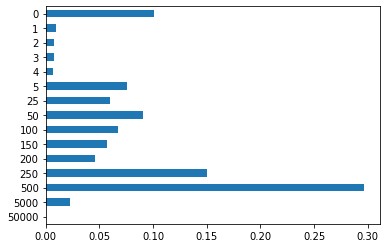

In [12]:
df.sold_quantity.value_counts(normalize=True).sort_index(ascending=False).plot.barh()

## Manipulación clases

In [13]:
df["sold_quantity"] = [x if x >= 5 else 1 for x in df["sold_quantity"]]

In [14]:
df.sold_quantity.value_counts().sort_index()

1        3061
5        1768
25       1384
50       2108
100      1556
150      1326
200      1078
250      3493
500      6885
5000      528
50000       7
Name: sold_quantity, dtype: int64

## Y

In [15]:
y = df.sold_quantity

In [16]:
df = df.drop(['sold_quantity'], axis= 1)

## Paths

In [17]:
cols_path = data_path + "cols.joblib" 
pipelines_path = data_path + "pipeline.joblib" 
models_path = data_path + "models/"
models_path_template = models_path + '{}.joblib'

## Load objects

In [18]:
# pipeline
pipeline = joblib.load(pipelines_path)
# cols
cols = joblib.load(cols_path)  


## Transform df

In [19]:
df_copy = df.copy()
df_copy = pipeline.transform(df_copy)

## Load models and predict

In [20]:
models = [ 'xgb', 
           'mlp', 
           'lr' 
]

In [21]:
dict_res = {}
for k in models:
    dict_res[k] = {}
    # ----------------- load model -------------------
    model = get_model(k, models_path_template.format(k))
    # ----------------- get preds -------------------
    preds = model.predict(df_copy[cols])
    dict_res[k]['model'] = model
    dict_res[k]['preds'] = preds

## --------------------------- <p style='color:blue; font-weight:bold'> XGB </p> ---------------------------

In [22]:
dict_res['xgb']['model']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=7, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=1111, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=None)

In [23]:
predicted_classes = dict_res['xgb']['preds']

In [24]:
classes = np.unique(predicted_classes)
classes

array([    1,     5,    25,    50,   100,   150,   200,   250,   500,
        5000, 50000])

In [25]:
print_pred_classes_prop(predicted_classes)

Predicted classes proportions
--------------
1        0.127662
5        0.089463
25       0.050875
50       0.095326
100      0.049754
150      0.037337
200      0.025739
250      0.133009
500      0.371389
5000     0.019186
50000    0.000259
dtype: float64 



Confusion matrix, without normalization


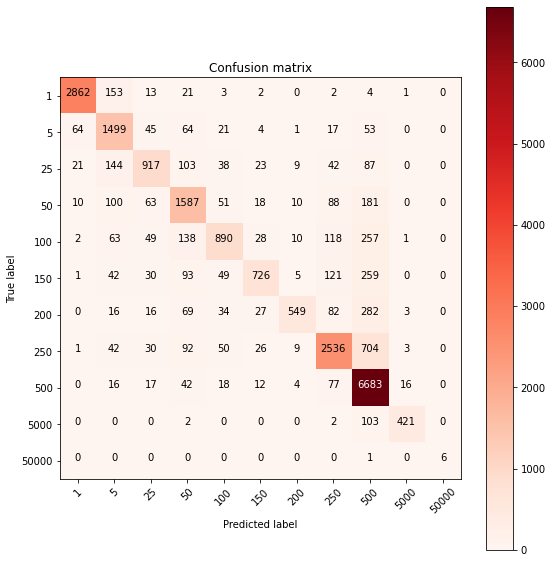

In [26]:
make_cmx(y, predicted_classes, classes, cmap=cmap)

In [27]:
make_classif_report(y, predicted_classes, classes)

,precision,recall,f1-score,support
1,0.97,0.93,0.95,3061.00
5,0.72,0.85,0.78,1768.00
25,0.78,0.66,0.72,1384.00
50,0.72,0.75,0.73,2108.00
100,0.77,0.57,0.66,1556.00
150,0.84,0.55,0.66,1326.00
200,0.92,0.51,0.66,1078.00
250,0.82,0.73,0.77,3493.00
500,0.78,0.97,0.86,6885.00
5000,0.95,0.80,0.87,528.00


## --------------------------- <p style='color:blue; font-weight:bold'> LR </p> ---------------------------

In [28]:
dict_res['lr']['model']

LogisticRegression(C=1, class_weight='balanced', multi_class='ovr',
                   random_state=1111, solver='saga')

In [29]:
predicted_classes = dict_res['lr']['preds']

In [30]:
classes = np.unique(predicted_classes)
classes

array([    1,     5,    25,    50,   100,   150,   200,   250,   500,
        5000, 50000], dtype=int64)

In [31]:
print_pred_classes_prop(predicted_classes)

Predicted classes proportions
--------------
1        0.108088
5        0.158920
25       0.041778
50       0.098862
100      0.087264
150      0.039622
200      0.042856
250      0.039579
500      0.096965
5000     0.279339
50000    0.006726
dtype: float64 



Confusion matrix, without normalization


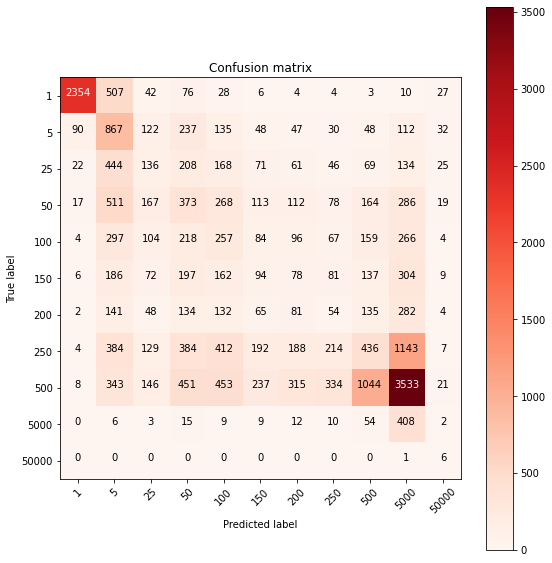

In [32]:
make_cmx(y, predicted_classes, classes, cmap=cmap)

In [33]:
make_classif_report(y, predicted_classes, classes)


,precision,recall,f1-score,support
1,0.94,0.77,0.85,3061.00
5,0.24,0.49,0.32,1768.00
25,0.14,0.10,0.12,1384.00
50,0.16,0.18,0.17,2108.00
100,0.13,0.17,0.14,1556.00
150,0.10,0.07,0.08,1326.00
200,0.08,0.08,0.08,1078.00
250,0.23,0.06,0.10,3493.00
500,0.46,0.15,0.23,6885.00
5000,0.06,0.77,0.12,528.00


## --------------------------- <p style='color:blue; font-weight:bold'> MLP </p> ---------------------------

In [34]:
dict_res['mlp']['model']

MLPClassifier(alpha=0.001, batch_size=64,
              hidden_layer_sizes=(64, 64, 64, 64, 64), learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=1800, random_state=1111,
              solver='sgd')

In [35]:
predicted_classes = dict_res['mlp']['preds']

In [36]:
classes = np.unique(predicted_classes)
classes

array([    1,     5,    25,    50,   100,   150,   200,   250,   500,
        5000, 50000], dtype=int64)

In [37]:
print_pred_classes_prop(predicted_classes)

Predicted classes proportions
--------------
1        0.127533
5        0.086186
25       0.055359
50       0.095801
100      0.065922
150      0.053936
200      0.040053
250      0.137579
500      0.315944
5000     0.021385
50000    0.000302
dtype: float64 



Confusion matrix, without normalization


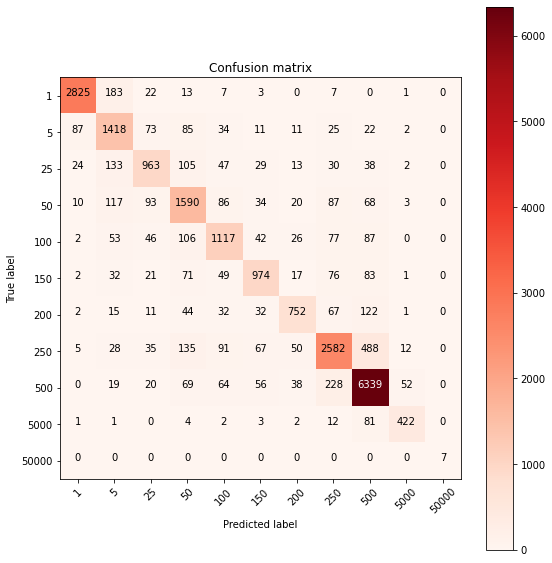

In [38]:
make_cmx(y, predicted_classes, classes, cmap=cmap)

In [39]:
make_classif_report(y, predicted_classes, classes)

,precision,recall,f1-score,support
1,0.96,0.92,0.94,3061.00
5,0.71,0.80,0.75,1768.00
25,0.75,0.70,0.72,1384.00
50,0.72,0.75,0.73,2108.00
100,0.73,0.72,0.72,1556.00
150,0.78,0.73,0.76,1326.00
200,0.81,0.70,0.75,1078.00
250,0.81,0.74,0.77,3493.00
500,0.87,0.92,0.89,6885.00
5000,0.85,0.80,0.82,528.00
